Implement an analysis about football soccer using data analysys visualization and SQL tools

$$100$$

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt


###EXPLANATION ABOUT BETTING COLUMNS AT      https://www.football-data.co.uk/notes.txt
##FROM https://www.football-data.co.uk/italym.php 
## Fetching data
#Connecting to database
path = "./"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)


In [513]:
#####Fetch all tables in sqlite database

sql_query = """SELECT * FROM sqlite_master  WHERE type='table';"""
all_tables=pd.read_sql(sql_query, conn)
all_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [522]:
###Store some tables in separate pandas
country_data = pd.read_sql("SELECT * FROM Country;", conn)
league_data = pd.read_sql("SELECT * FROM League;", conn)
league_data["country_name"]=country_data["name"]
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team ORDER BY team_long_name;", conn)
team_stats_data=pd.read_sql("SELECT * FROM Team_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [523]:
print("The following countries are available \n")
print(list(league_data.country_name),"\n")


print("The names of the leagues are \n")
print(list(league_data.name))



The following countries are available 

['Belgium', 'England', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Scotland', 'Spain', 'Switzerland'] 

The names of the leagues are 

['Belgium Jupiler League', 'England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A', 'Netherlands Eredivisie', 'Poland Ekstraklasa', 'Portugal Liga ZON Sagres', 'Scotland Premier League', 'Spain LIGA BBVA', 'Switzerland Super League']


In [529]:
###Merge player_name and player_stats tables 

players_all_data=pd.merge(player_stats_data,player_data,how="outer",on=["player_api_id"])
players_all_data["Date"]=pd.to_datetime(players_all_data.date)
players_all_data["year"]=players_all_data["Date"].apply(lambda x: x.year)

##Check that merging works with this example!!!
#df1=player_data.sort_values("player_api_id")[["player_api_id","player_name","height"]][:]
#print(df1)
#df2=player_stats_data.sort_values("player_api_id")[["player_api_id","overall_rating","date","potential","crossing"]][:]
#print(df2)
#dftot=pd.merge(df1,df2,how="outer",on=["player_api_id"])
#dftot["Date"]=pd.to_datetime(dftot.date)
#dftot["year"]=dftot["Date"].apply(lambda x: x.year)
#----------


In [568]:
df=players_all_data.sort_values("year")
df_yearly=df.groupby("year").mean()
df_yearly

,id_x,player_fifa_api_id_x,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_fifa_api_id_y,height,weight
year,,,,,,,,,,,,,,,,,,,,,
2007,92144.544553,151320.148407,119976.425951,64.555967,72.195559,50.201402,47.042008,54.640306,57.218153,47.045666,...,46.437765,14.274899,19.510778,42.019413,19.530126,19.881249,5528.850477,151292.229706,181.919591,168.949188
2008,91700.387547,130967.647465,51154.655571,66.988440,74.100069,53.438233,49.218599,57.649931,59.902864,49.783588,...,48.196130,14.363527,24.797619,54.129227,24.819013,25.254313,5502.074164,130949.419110,182.106347,170.249914
2009,91904.132659,137225.128656,59709.713110,68.236707,75.166073,54.812013,49.826251,57.849499,61.200000,49.830131,...,48.083529,14.135373,25.218020,55.624027,25.230256,25.656507,5514.566218,137209.071611,182.189994,170.341154
2010,91242.966202,144666.449441,73179.963986,68.172041,74.916936,54.275247,48.824910,56.979303,61.240599,48.834055,...,47.015728,15.080292,19.604823,32.027626,19.657581,20.012011,5475.013021,144635.253024,182.116991,170.074430
2011,91751.333834,151537.136356,87284.571142,68.472343,73.963235,53.808740,47.747744,56.176972,61.205381,47.853526,...,46.474014,16.336397,16.042029,15.853192,16.089154,16.470003,5505.687709,151503.558951,182.174798,170.018370
2012,91816.149937,159621.585022,105619.126504,68.536079,73.038812,54.193743,48.169267,56.590495,61.826614,48.107406,...,47.021228,15.459960,15.142257,14.994535,15.223604,15.535287,5509.716434,159593.056444,182.030451,169.353467
2013,91798.692516,166632.574240,129118.401678,68.968736,73.383827,55.300541,49.794386,57.139866,62.743472,49.319341,...,47.659464,15.209348,14.906438,14.749730,14.986402,15.334046,5508.610029,166601.626779,181.949531,168.966192
2014,91746.045233,174496.249543,155395.993721,68.944255,72.971334,56.210783,50.930379,58.077153,63.403727,50.193340,...,49.036106,14.192974,13.935869,13.760551,13.962155,14.249177,5505.613113,174454.812028,181.769176,168.432120
2015,92769.365553,182858.958503,189252.057737,69.578258,73.398328,56.466874,51.359356,57.841505,64.178390,50.303727,...,48.791219,14.264379,14.020774,13.873342,14.114149,14.351468,5567.537350,182808.676132,181.615904,167.635201


Index(['id_x', 'player_fifa_api_id_x', 'player_api_id', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'id_y', 'player_name', 'player_fifa_api_id_y',
       'birthday', 'height', 'weight', 'Date', 'year'],
      dtype='object')
Lionel Messi
Cristiano Ronaldo
Ronaldinho


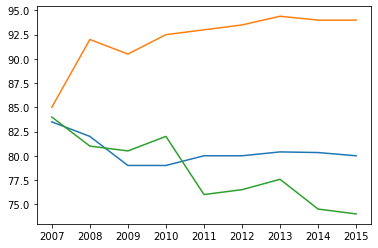

In [558]:
df=players_all_data.sort_values("year")
print(df.columns)
my_player_list=["Lionel Messi","Cristiano Ronaldo","Ronaldinho"]


#dfout=df[df.player_name=="Lionel Messi"]
#dfout=dfout.groupby("year").mean()
for playerstr in my_player_list:
    print(playerstr)
    dfout=df[df.player_name==playerstr]
    dfout=dfout.groupby("year").mean()
    plt.plot(dfout.index,dfout["shot_power"])


In [19]:
## Select country and display all available seasons
country_name="Italy"
team_name="Juventus"
league_name=None
season_name=None



In [ ]:
if myinput in [country_title,team_name,league_name,season_name]:
    print("We chosed:",myinput)

country_id=country_data[country_data["name"]==country_title].id
serie_A_matches=match_data[match_data.country_id==int(country_id)]

all_season=list(serie_A_matches.season.unique())
print("Seasons available are \n",all_season)




In [ ]:
if myinput in [country_title,team_name,league_name,season_name]:
    print("We chosed:",myinput)

country_id=country_data[country_data["name"]==country_title].id
serie_A_matches=match_data[match_data.country_id==int(country_id)]

all_season=list(serie_A_matches.season.unique())
print("Seasons available are \n",all_season)




In [451]:
#(serie_A_matches.columns).intersection((team_data.columns))

In [426]:
###Pick one season and select one team
serie_A_matches=serie_A_matches[serie_A_matches.season==all_season[-1]]
print("total number of matches in the whole season", len(serie_A_matches))
###Select all the team's matches and season 
team_number=int(team_data[team_data.team_long_name=="Milan"].team_api_id)
team_matches=serie_A_matches[(serie_A_matches.home_team_api_id==team_number) | (serie_A_matches.away_team_api_id==team_number)]
print("each team plays a total of ",len(team_matches)," games")
print("Total number of teams ",len(serie_A_matches.home_team_api_id.unique()))

seriea_A_teams=team_data[team_data["team_api_id"].isin(list(serie_A_matches.home_team_api_id.unique())) ]


total number of matches in the whole season 240
each team plays a total of  0  games
Total number of teams  16


In [414]:
seriea_A_teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
22,43051,8315,448.0,Athletic Club de Bilbao,BIL
23,43053,9906,240.0,Atlético Madrid,AMA
39,43037,8371,479.0,CA Osasuna,OSA
41,43041,8388,477.0,CD Numancia,NUM
75,43042,8634,241.0,FC Barcelona,BAR
112,43046,8305,1860.0,Getafe CF,GET
168,43054,9864,573.0,Málaga CF,MAL
200,43039,9783,242.0,RC Deportivo de La Coruña,COR
202,43048,8479,571.0,RC Recreativo,HUE
203,43049,8558,452.0,RCD Espanyol,ESP


In [421]:
match_data.B365H

0        1.73
1        1.95
2        2.38
3        1.44
4        5.00
         ... 
25974     NaN
25975     NaN
25976     NaN
25977     NaN
25978     NaN
Name: B365H, Length: 25979, dtype: float64

In [420]:
list(match_data.columns)

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player

In [402]:
Milan_Statistics = pd.read_sql("""SELECT *
 
                                        FROM Team 

                                        left join Team_Attributes
                                        
                                        on Team_Attributes.team_api_id = Team.team_api_id
                                        
                                        where team_long_name= "Milan"
                                        
                        
                        """, conn)

In [405]:
Milan_Statistics.date

0    2010-02-22 00:00:00
1    2011-02-22 00:00:00
2    2012-02-22 00:00:00
3    2013-09-20 00:00:00
4    2014-09-19 00:00:00
5    2015-09-10 00:00:00
Name: date, dtype: object